# Let's how class TrendLine is working

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

class TrendLine(object):
    
    def smoothing(self, data, dim, sig_ob=1.0, sig_sys=1.0e-1):
        #dim is the dimention of trend model
        #make data for analysis
        data_list = []
        data_def = np.array(data)
        data_list.append(data_def)
        for i in xrange(dim):
            data_def = data_def[1:] - data_def[:-1]
            data_list.append(data_def)
            
        #reshape data for available
        N_data = len(data_list[-1])
        for i in xrange(len(data_list)):
            data_list[i] = data_list[i][-N_data:]
        
        #matrix for state space model 
        #x = Fx + Gv
        #y = Hx + w
        #Q, R is variance matrix for v, w respectively
        F = np.tri(dim + 1).T
        G = np.tri(dim + 1).T
        R = sig_ob**2*np.identity(dim + 1)
        Q = sig_sys**2*np.identity(dim + 1)
        x_data = np.array(data_list).T
        
        #filtering step
        V_pred_data = []
        V_filt_data = []
        x_pred_data = []
        x_filt_data = []
        x_filt = x_data[0]
        x_filt_data.append(x_filt)
        V_filt = R
        V_filt_data.append(V_filt)
        for x in iter(x_data[1:]):
            x_pred = np.dot(F, x_filt)
            V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
            kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
            x_filt = x_pred + np.dot(kal_gain, x - x_pred)
            V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
            #store data for smoothing
            x_pred_data.append(x_pred)
            V_pred_data.append(V_pred)
            x_filt_data.append(x_filt)
            V_filt_data.append(V_filt)
            
        #smoothing step
        N_pred_data = len(V_pred_data)
        x_sm_data = []
        x_sm = x_filt_data[-1]
        x_sm_data.append(x_sm[0])
        V_sm = V_filt_data[-1]
        for i in xrange(N_pred_data):
            idx = N_pred_data - i - 1
            smoother = np.dot(V_filt_data[idx], np.dot(F.T, np.linalg.inv(V_pred_data[idx])))
            x_sm = x_filt_data[idx] + np.dot(smoother, x_sm - x_pred_data[idx])
            V_sm = V_filt_data[idx] + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
            x_sm_data.append(x_sm[0])
            
        x_sm_data.reverse()
        #insert raw data to value at t=0, 1, ..., dim-1
        x_sm_data = np.r_[data[range(dim)], x_sm_data]
        
        return x_sm_data
    
    #find local maximum point for high_data, local minimum for low_data
    def get_max_idx(self, data, is_high=True, dim=4, window=2, sig_ob=1.0, sig_sys=1.0e-1):
        smoothed_data = self.smoothing(data, dim=dim, sig_ob=sig_ob, sig_sys=sig_sys)
        data_tilde = np.array(smoothed_data)
        if is_high is not True:
            data_tilde = -data_tilde
        T = len(data_tilde)
    
        #regularize data by getting rid of trend of data
        reg = LinearRegression()
        time_data = np.arange(T)
        x = time_data.reshape(T, 1)
        y = np.array(data_tilde).reshape(T, 1)
        reg.fit(x, y)
        coef = reg.coef_[0][0]
        reg_data = data_tilde - coef*time_data
    
        #data for first order derivative
        def_data = reg_data[1:] - reg_data[:-1]
    
        #find local optimum point
        idx_max = []
        for i in xrange(1, T - 1):
            if def_data[i] <=0 and def_data[i-1] >= 0:
                idx_max.append(i)

        #determine weahter selected points are local maximum in their more global neighbor
        new_idx_max = []
        for idx in iter(idx_max):
            flag = True
            max_value = reg_data[idx]
            for slide in xrange(1, window + 1):
                slide_idx = idx + slide
                if slide_idx > T - 1:
                    continue
                if max_value < reg_data[slide_idx]:
                    flag = False
                    break
        
            for slide in xrange(1, window + 1):
                slide_idx = idx - slide
                if slide_idx < 0:
                    continue
                if max_value < reg_data[slide_idx]:
                    flag = False 
                    break
            if flag:
                new_idx_max.append(idx)             
    
        return new_idx_max
    
    #given data and slope of the line, return the intercept of the line which will not go below conf_lev numbers y_data
    def get_opt_incpt(self, x_data, y_data, coef, conf_lev=1, is_high=True):
        #conf_lev is the number of points to judge validity of support and resistance 
        assert len(x_data)>=1 and len(y_data) >=1, "you should input some data"
        #for the case of resistance
        if is_high is not True:
            y_data= (-1)*y_data
            coef= -coef   
        
        #generate line data and check how much points cross that line
        N_data = len(x_data)
        for i in xrange(N_data):
            x = x_data[i]
            y = y_data[i]
            incpt = y - coef*x
            line_data = coef*x_data + incpt
            over_flag = 0
            for j in xrange(N_data):
                if i==j: continue
                if y_data[j] > line_data[j]:
                    over_flag += 1
            if over_flag == conf_lev - 1: 
                opt_incpt = incpt
                break   
        
        if is_high is not True:
            opt_incpt = -opt_incpt
        
        return opt_incpt
    
    #return slope and  intercept of optimal line 
    def opt_line(self, data, is_high=True, dim=4, window=1, sig_ob=1.0, sig_sys=1.0e-1):
        #window is the figure about how much points around what you pick up when drawing line
        data = np.array(data)
        max_idx = self.get_max_idx(data, is_high=is_high, dim=dim)
        N_data = len(data)
        time_data = np.arange(N_data)
    
        #take loc_maximal's neighbor into consideration
        new_max_idx = []
        N_idx = len(max_idx)
        for i in xrange(N_idx):
            for slide in xrange(1, window + 1):
                slide = window + 1 - slide
                slide_idx = max_idx[i] - slide
                if slide_idx < 0:
                    break
                if i != 0 and slide_idx == max_idx[i - 1]:
                     break
                new_max_idx.append(slide_idx)
            
            new_max_idx.append(max_idx[i])
        
            for slide in xrange(1, window + 1):
                slide_idx = max_idx[i] + slide
                if slide_idx > N_data - 1:
                    break
                if i != N_idx - 1 and slide_idx == max_idx[i -+1]:
                     break
                new_max_idx.append(slide_idx)
        
        y = data[new_max_idx]
        x = time_data[new_max_idx]
        reg_y = y.reshape(len(y), 1)
        reg_x = x.reshape(len(x), 1)
        reg = LinearRegression()
        reg.fit(reg_x, reg_y)
        coef = reg.coef_[0][0]
        incpt = self.get_opt_incpt(x_data=x, y_data=y, coef=coef, conf_lev=1, is_high=is_high)
        
        return coef, incpt
    
    
    #get list support, resistance line data, and their corresponding time data
    def draw_line(self, high_data, low_data, slide=10, tolerance=3, num_max=2, flag_sm=True, dim=4):
        assert len(high_data) == len(low_data), "length of low_data and high_data should be the same"
        high_data = np.array(high_data)
        low_data = np.array(low_data)
        if flag_sm:
            high_data = self.smoothing(high_data, dim=dim)
            low_data = self.smoothing(low_data, dim=dim)
        N_data = len(high_data)
        N_iter = N_data/slide
        begin = 0
        high_line_data = []
        low_line_data = []
        time_data = np.arange(N_data)
        time_data_list = []
        line_flag = False #flag to check weather there is a line or not
        for i in xrange(N_iter):
            end = (i + 1)*slide
            high_data_mini = high_data[begin:end]
            low_data_mini = low_data[begin:end]
            max_idx = self.get_max_idx(high_data_mini, is_high=True, dim=4, window=2, sig_ob=1.0, sig_sys=1.0e-1)
            min_idx = self.get_max_idx(low_data_mini, is_high=False, dim=4, window=2, sig_ob=1.0, sig_sys=1.0e-1)
        
            # if you fail to find enaough local maximum or minimum point, you will increase points. 
            if len(max_idx) < num_max or len(min_idx) < num_max:
                continue
            
            #draw line
            if line_flag is False:
                high_coef, high_incpt = self.opt_line(high_data_mini, is_high=True)
                low_coef, low_incpt = self.opt_line(low_data_mini, is_high=False)
                line_flag = True
        
            x = np.arange(end - begin)
            high_line = high_coef * x + high_incpt
            low_line  = low_coef * x + low_incpt
        
            #count for how many points break the line
            high_count = 0
            low_count = 0
            for time_idx in xrange(max_idx[1], end - begin):
                high_count += 1
                low_count += 1
                if high_data_mini[time_idx] <= high_line[time_idx]:
                    high_count = 0
            
                if low_data_mini[time_idx] >= low_line[time_idx]:
                    low_count = 0
                
                if high_count > tolerance or low_count > tolerance:
                    print ("break the line!, t=%d" %(time_idx - tolerance + begin))
                    time_data_list.append(time_data[begin:end])
                    if max_idx[1] > min_idx[1]:
                        begin = min_idx[1] - 1 + begin
                    else:
                        begin = max_idx[1] - 1 + begin
                    high_line_data.append(high_line)
                    low_line_data.append(low_line)
                    line_flag = False
                    break
        
        if line_flag is True:
            high_line_data.append(high_line)
            low_line_data.append(low_line)
            time_data_list.append(time_data[begin:end])
                
        return high_line_data, low_line_data, time_data_list
                
            
            

    
    

# Get the historical data

In [8]:
# generic
%matplotlib inline
from __future__ import print_function

# common
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# local
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter
from tseries.indicators import get_functions

# for testing purpose
from IPython import display
import platform
#import plotly
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import tqdm
import time
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

def list_packages_versions():
    !date
    print("\ncompiler    : %s"%platform.python_compiler())
    l = platform.linux_distribution()
    print("system      : %s, %s, %s, %s"%(platform.system(),platform.release(),l[0],l[1]))
    print("processor   : %s, %s\n"%(platform.processor(),platform.architecture()[0]))
    
    a = %who_ls module
    for i in a:
        try:
            print("%s %s"%(("%s (%s) "%(globals()[i].__name__,i)).ljust(20,'_'),globals()[i].__version__))
        except:
            pass
list_packages_versions()

Sun May  8 16:27:39 UTC 2016

compiler    : GCC 4.8.2
system      : Linux, 3.19.0-51-generic, Ubuntu, 14.04
processor   : x86_64, 64bit

json (json) ________ 2.0.9
numpy (np) _________ 1.11.0
pandas (pd) ________ 0.16.2
platform (platform)  1.0.7
seaborn (sns) ______ 0.6.0


In [9]:
parse_datetime = tm.T.parser("%Y%m%d%H%M")
reference_score = compare.load_reference(parse_json(load_json("/project/exp/reference/downtrend_2015test_1a.json")),
                                         "EURUSD", "5Min", parse_datetime("201501010000"),
                                         parse_datetime("201601010000"))

h5 = histdata.get_pandadb()
symbol="EURJPY"
timeframe="5Min"
df = h5[histdata.get_table_name(symbol, timeframe)]

beginning, end = "2015-01-02 08:00:00" , "2015-05-29 21:55:00"
ref = reference_score[beginning : end]
df = df[beginning : end]

ohlc_data = pd.concat([
        df.iloc[:13704],
        pd.DataFrame({"open":[129.636], "high": [129.589], "low": [129.586], "close": [129.58]},
                     index=[pd.to_datetime("2015-03-10 22:00:00+0000",utc=True)]),
        df.iloc[13704:]    
    ])

def df_to_array(df):
    data_list = []
    for key in df.columns:
        data_list.append(df[key])
    return np.array(data_list)

ohlc_array = df_to_array(ohlc_data)
high_data = np.array(ohlc_data['high'])
low_data = np.array(ohlc_data['low'])
open_data = np.array(ohlc_data["open"])
close_data = np.array(ohlc_data["close"])

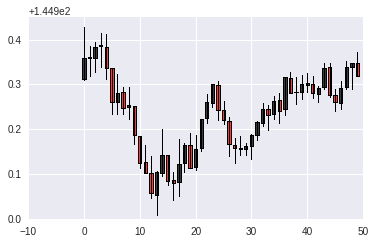

In [10]:
from matplotlib.finance import candlestick2_ohlc

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, ohlc_data["open"][:50], ohlc_data["high"][:50], 
                  ohlc_data["low"][:50], ohlc_data["close"][:50],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

break the line!, t=33
break the line!, t=52
break the line!, t=80
break the line!, t=103
break the line!, t=129
break the line!, t=153


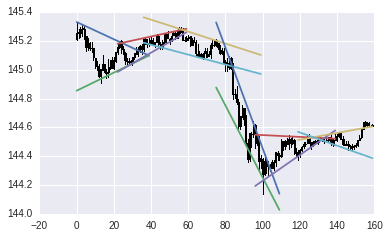

In [14]:
N = 160
M = 0
k = 4

trend = TrendLine()

high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])

N_data = len(smoothed_high)
time_data = np.arange(N_data)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, open_data[M:N], high_data[M:N], 
                  low_data[M:N], close_data[M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)

high_line, low_line, time_data_list = trend.draw_line(high_data_mini, low_data_mini)
             
for i in xrange(len(high_line)):
    plt.plot(time_data_list[i], high_line[i])
    plt.plot(time_data_list[i], low_line[i])
plt.legend()

To combine this with app, I will set the format of input the same as the output of as "get_range"

https://github.com/AlpacaDB/trading/blob/develop/python/lib/tseries/chartdata.py

I will set the output as the two list: low lines([[start, end], [start, end]]), and high lins([[start, end], [start, end]...])

In [105]:
import histdata
from trading import tm

parse_datetime = tm.T.parser("%Y%m%d%H%M")
print (parse_datetime("201501010000"))
st = parse_datetime("201501010000")
end = parse_datetime("201601010000")

df = histdata.get_candles(symbol="EURUSD", timeframe="5Min", start=st, end=end)

high_data = np.array(df['high'])
low_data = np.array(df['low'])
open_data = np.array(df['open'])
close_data = np.array(df['close'])

2015-01-01 00:00:00+00:00


In [106]:
print (df.index[0])

2015-01-01 18:00:00+00:00


In [87]:
print (df["high"][0:10])

2016-01-03 22:00:00+00:00    1.08758
2016-01-03 22:05:00+00:00    1.08741
2016-01-03 22:10:00+00:00    1.08714
2016-01-03 22:15:00+00:00    1.08696
2016-01-03 22:20:00+00:00    1.08723
2016-01-03 22:25:00+00:00    1.08698
2016-01-03 22:30:00+00:00    1.08712
2016-01-03 22:35:00+00:00    1.08705
2016-01-03 22:40:00+00:00    1.08693
2016-01-03 22:45:00+00:00    1.08692
Name: high, dtype: float64


In [52]:
df.values

array([[ 1.08751,  1.08758,  1.08729,  1.08729],
       [ 1.08729,  1.08741,  1.08714,  1.08714],
       [ 1.08714,  1.08714,  1.08677,  1.08677],
       ..., 
       [ 1.08349,  1.08362,  1.08341,  1.08343],
       [ 1.08343,  1.08344,  1.08325,  1.08328],
       [ 1.08328,  1.08335,  1.08302,  1.08328]])

In [54]:
df['open'].values

array([ 1.08751,  1.08729,  1.08714, ...,  1.08349,  1.08343,  1.08328])

In [108]:
df.index[0]


Timestamp('2015-01-01 18:00:00+0000', tz='UTC')

In [56]:
len(df)

5760

In [95]:
import numpy as np
from sklearn.linear_model import LinearRegression

def smoothing(data, dim, sig_ob=1.0, sig_sys=1.0e-1):
    #dim is the dimention of trend model
    #make data for analysis
    data_list = []
    data_def = np.array(data)
    data_list.append(data_def)
    for i in xrange(dim):
        data_def = data_def[1:] - data_def[:-1]
        data_list.append(data_def)
            
    #reshape data for available
    N_data = len(data_list[-1])
    for i in xrange(len(data_list)):
        data_list[i] = data_list[i][-N_data:]
        
    #matrix for state space model 
    #x = Fx + Gv
    #y = Hx + w
    #Q, R is variance matrix for v, w respectively
    F = np.tri(dim + 1).T
    G = np.tri(dim + 1).T
    R = sig_ob**2*np.identity(dim + 1)
    Q = sig_sys**2*np.identity(dim + 1)
    x_data = np.array(data_list).T
        
    #filtering step
    V_pred_data = []
    V_filt_data = []
    x_pred_data = []
    x_filt_data = []
    x_filt = x_data[0]
    x_filt_data.append(x_filt)
    V_filt = R
    V_filt_data.append(V_filt)
    for x in iter(x_data[1:]):
        x_pred = np.dot(F, x_filt)
        V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
        kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
        x_filt = x_pred + np.dot(kal_gain, x - x_pred)
        V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
        #store data for smoothing
        x_pred_data.append(x_pred)
        V_pred_data.append(V_pred)
        x_filt_data.append(x_filt)
        V_filt_data.append(V_filt)
            
    #smoothing step
    N_pred_data = len(V_pred_data)
    x_sm_data = []
    x_sm = x_filt_data[-1]
    x_sm_data.append(x_sm[0])
    V_sm = V_filt_data[-1]
    for i in xrange(N_pred_data):
        idx = N_pred_data - i - 1
        smoother = np.dot(V_filt_data[idx], np.dot(F.T, np.linalg.inv(V_pred_data[idx])))
        x_sm = x_filt_data[idx] + np.dot(smoother, x_sm - x_pred_data[idx])
        V_sm = V_filt_data[idx] + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
        x_sm_data.append(x_sm[0])
            
    x_sm_data.reverse()
    #insert raw data to value at t=0, 1, ..., dim-1
    x_sm_data = np.r_[data[range(dim)], x_sm_data]
        
    return x_sm_data
    
#find local maximum point for high_data, local minimum for low_data
def get_max_idx(data, is_high=True, window=2, sig_ob=1.0, sig_sys=1.0e-1):

    data_tilde = np.array(data)
    if is_high is not True:
        data_tilde = -data_tilde
    T = len(data_tilde)
    
    #regularize data by getting rid of trend of data
    reg = LinearRegression()
    time_data = np.arange(T)
    x = time_data.reshape(T, 1)
    y = np.array(data_tilde).reshape(T, 1)
    reg.fit(x, y)
    coef = reg.coef_[0][0]
    reg_data = data_tilde - coef*time_data
    
    #data for first order derivative
    def_data = reg_data[1:] - reg_data[:-1]
    
    #find local optimum point
    idx_max = []
    for i in xrange(1, T - 1):
        if def_data[i] <=0 and def_data[i-1] >= 0:
            idx_max.append(i)

    #determine weahter selected points are local maximum in their more global neighbor
    new_idx_max = []
    for idx in iter(idx_max):
        flag = True
        max_value = reg_data[idx]
        for slide in xrange(1, window + 1):
            slide_idx = idx + slide
            if slide_idx > T - 1:
                continue
            if max_value < reg_data[slide_idx]:
                flag = False
                break
    
        for slide in xrange(1, window + 1):
            slide_idx = idx - slide
            if slide_idx < 0:
                continue
            if max_value < reg_data[slide_idx]:
                flag = False 
                break
        if flag:
            new_idx_max.append(idx)             
    
    return new_idx_max
    
#given data and slope of the line, return the intercept of the line which will not go below conf_lev numbers y_data
def get_opt_incpt(x_data, y_data, coef, conf_lev=1, is_high=True):
    #conf_lev is the number of points to judge validity of support and resistance 
    assert len(x_data)>=1 and len(y_data) >=1, "you should input some data"
    #for the case of resistance
    if is_high is not True:
        y_data= (-1)*y_data
        coef= -coef   
        
    #generate line data and check how much points cross that line
    N_data = len(x_data)
    for i in xrange(N_data):
        x = x_data[i]
        y = y_data[i]
        incpt = y - coef*x
        line_data = coef*x_data + incpt
        over_flag = 0
        for j in xrange(N_data):
            if i==j: continue
            if y_data[j] > line_data[j]:
                over_flag += 1
        if over_flag == conf_lev - 1: 
            opt_incpt = incpt
            break   
        
    if is_high is not True:
        opt_incpt = -opt_incpt
        
    return opt_incpt
    
#return slope and  intercept of optimal line 
def opt_line(data, is_high=True, dim=4, window=1, sig_ob=1.0, sig_sys=1.0e-1):
    #window is the figure about how much points around what you pick up when drawing line
    data = np.array(data)
    max_idx = get_max_idx(data, is_high=is_high)
    N_data = len(data)
    time_data = np.arange(N_data)
    
    #take loc_maximal's neighbor into consideration
    new_max_idx = []
    N_idx = len(max_idx)
    for i in xrange(N_idx):
        for slide in xrange(1, window + 1):
            slide = window + 1 - slide
            slide_idx = max_idx[i] - slide
            if slide_idx < 0:
                break
                if i != 0 and slide_idx == max_idx[i - 1]:
                    break
            new_max_idx.append(slide_idx)
            
        new_max_idx.append(max_idx[i])
        
        for slide in xrange(1, window + 1):
            slide_idx = max_idx[i] + slide
            if slide_idx > N_data - 1:
                break
            if i != N_idx - 1 and slide_idx == max_idx[i -+1]:
                 break
            new_max_idx.append(slide_idx)
        
    y = data[new_max_idx]
    x = time_data[new_max_idx]
    reg_y = y.reshape(len(y), 1)
    reg_x = x.reshape(len(x), 1)
    reg = LinearRegression()
    reg.fit(reg_x, reg_y)
    coef = reg.coef_[0][0]
    incpt = get_opt_incpt(x_data=x, y_data=y, coef=coef, conf_lev=1, is_high=is_high)
        
    return coef, incpt
    
    
#get list support, resistance line data, and their corresponding time data
def draw_line(data, slide=10, tolerance=3, num_max=2, flag_sm=True, dim=4):
    """
    data:
    dict: timeseries data
        {
            "Date": [...],
            "<indicator_id_1>": [...],
            "<indicator_id_2>": [...],
            "<indicator_id_3>": [...],
            "<indicator_id_4>": [...],
            ...
        }
            
    Return:
    list:
        beg_end_list = [[begin_time, end_time], [begin_time, end_time], ...]
        high_line_list = [[begin_value, end_value], [begin_value, end_value], ...]
        low_line_list = [[begin_value, end_value], [begin_value, end_value], ...]
        
    they should satisfy following     
    high(low)_line_data[begin(end)_time] == begin(end)_value  
    """
    time_data = data['Date']
    high_data = np.array(data['High'])
    low_data = np.array(data['Low'])
        
    if flag_sm:
        high_data = smoothing(high_data, dim=dim)
        low_data = smoothing(low_data, dim=dim)
        
    #they will be return value
    high_line_list = []
    low_line_list = []
    beg_end_list = []
    index_list = []
        
    N_data = len(high_data)
    N_iter = N_data/slide
       
    idx_data = np.arange(N_data)
    line_flag = False #flag to check weather there is a line or not
        
    begin = 0 #index of beggining value
    for i in xrange(N_iter):
        end = (i + 1)*slide - 1 #index of end value
        high_data_mini = high_data[begin:end]
        low_data_mini = low_data[begin:end]
        max_idx = get_max_idx(high_data_mini, is_high=True, window=2, sig_ob=1.0, sig_sys=1.0e-1)
        min_idx = get_max_idx(low_data_mini, is_high=False, window=2, sig_ob=1.0, sig_sys=1.0e-1)
        
        # if you fail to find enaough local maximum or minimum point, you will increase points. 
        if len(max_idx) < num_max or len(min_idx) < num_max:
            continue
            
        #draw line
        if line_flag is False:
            high_coef, high_incpt = opt_line(high_data_mini, is_high=True)
            low_coef, low_incpt = opt_line(low_data_mini, is_high=False)
            line_flag = True
        
        x = np.arange(end - begin)
        high_line = high_coef * x + high_incpt
        low_line  = low_coef * x + low_incpt
        
        #count for how many points break the line
        high_count = 0
        low_count = 0
        for time_idx in xrange(max_idx[1], end - begin):
            high_count += 1
            low_count += 1
            if high_data_mini[time_idx] <= high_line[time_idx]:
                high_count = 0
            
            if low_data_mini[time_idx] >= low_line[time_idx]:
                low_count = 0
                
            if high_count > tolerance or low_count > tolerance:
                print ("break the line!, t=%d" %(time_idx - tolerance + begin))
                beg_end_list.append([time_data[begin], time_data[end]])
                high_line_list.append([high_line[0], high_line[-1]])
                low_line_list.append([low_line[0], low_line[-1]])
                index_list.append([begin, end])
                if max_idx[1] > min_idx[1]:
                    begin = min_idx[1] - 1 + begin
                else:
                    begin = max_idx[1] - 1 + begin
                line_flag = False
                break
        
    if line_flag is True:
        beg_end_list.append([time_data[begin], time_data[end]])
        high_line_list.append([high_line[0], high_line[-1]])
        low_line_list.append([low_line[0], low_line[-1]])
        index_list.append([begin, end])
                
    return beg_end_list, high_line_list, low_line_list, index_list
        

In [96]:

def draw_line_by_list(index_list, line_data_list):
    x_list = []
    y_list = []
    for index, line_data in zip(index_list, line_data_list):
        x = np.arange(index[0], index[1] + 1)
        slope = (line_data[1] - line_data[0])/(index[1] - index[0])
        y = slope*(x - index[0]) + line_data[0]
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list
        


break the line!, t=44
break the line!, t=56
break the line!, t=83


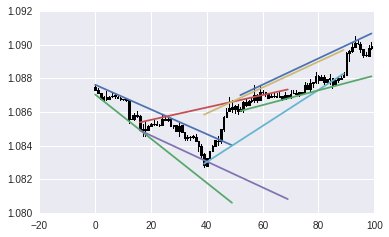

In [99]:
N = 100
M = 0
k = 4

high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
df_mini = df[M:N]

beg_end_list, high_line, low_line, index_list = draw_line(df_mini)

N_data = len(high_data_mini)
time_data = np.arange(N_data)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, open_data[M:N], high_data[M:N], 
                  low_data[M:N], close_data[M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)

high_x, high_y= draw_line_by_list(index_list, high_line)
low_x, low_y= draw_line_by_list(index_list, low_line)

for i in xrange(len(high_x)):
    plt.plot(high_x[i], high_y[i])
    plt.plot(low_x[i], low_y[i])
plt.legend()

In [ ]:
N = 5000
M = 0
k = 4

high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
df_mini = df[M:N]

beg_end_list, high_line, low_line, index_list = draw_line(df_mini)

N_data = len(high_data_mini)
time_data = np.arange(N_data)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, open_data[M:N], high_data[M:N], 
                  low_data[M:N], close_data[M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)

high_x, high_y= draw_line_by_list(index_list, high_line)
low_x, low_y= draw_line_by_list(index_list, low_line)

for i in xrange(len(high_x)):
    plt.plot(high_x[i], high_y[i])
    plt.plot(low_x[i], low_y[i])
plt.legend()

This program seems now working well when we use long term data.

In [109]:
print (beg_end_list)

[[Timestamp('2016-01-03 22:00:00+0000', tz='UTC'), Timestamp('2016-01-04 02:05:00+0000', tz='UTC')], [Timestamp('2016-01-03 23:20:00+0000', tz='UTC'), Timestamp('2016-01-04 03:45:00+0000', tz='UTC')], [Timestamp('2016-01-04 01:15:00+0000', tz='UTC'), Timestamp('2016-01-04 05:25:00+0000', tz='UTC')], [Timestamp('2016-01-04 02:20:00+0000', tz='UTC'), Timestamp('2016-01-04 06:15:00+0000', tz='UTC')]]


In [117]:
import pandas

type(beg_end_list[0][0]) == pandas.tslib.Timestamp

True

In [121]:
isinstance(beg_end_list[0][0], pandas.tslib.Timestamp)

True